**Importer les bibliotheques necessaires**

In [ ]:
from google.colab import drive
import zipfile
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, Flatten, Input, MaxPooling1D, Bidirectional, Reshape, SimpleRNN
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import random

**Chargement des donnes**

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/time series project/best_track.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,cyclone_id,datetime,flag,intensity,latitude,longitude,num_data_lines,pressure,revision_date,storm_name,time_interval,track_sequence,wind
0,CYC000001,1949011300,0,0,57,1399,49,1006,20110729.0,Carmen,6,1,0
1,CYC000001,1949011306,0,0,59,1393,49,1006,20110729.0,Carmen,6,2,0
2,CYC000001,1949011312,0,0,63,1387,49,1006,20110729.0,Carmen,6,3,0
3,CYC000001,1949011318,0,0,67,1380,49,1006,20110729.0,Carmen,6,4,0
4,CYC000001,1949011400,0,0,72,1373,49,1005,20110729.0,Carmen,6,5,0


In [ ]:
import pickle
scaler = MinMaxScaler()
df[['latitude', 'longitude']] = scaler.fit_transform(df[['latitude', 'longitude']])
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


**Determiner le meilleur model**

helper fuctions

In [ ]:
def reshape_for_mlp(X):
    return X.reshape((X.shape[0], -1))

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        # Input sequence with both lat and long
        x = data[i:i + seq_length][['latitude', 'longitude']].values
        # Output is both lat and long for the next position
        y = data.iloc[i + seq_length][['latitude', 'longitude']].values
        xs.append(x)
        ys.append(y)
    # Return numpy arrays if sequences were created, otherwise return empty lists
    if xs and ys:
        return np.array(xs), np.array(ys)
    else:
        return [], []

def train_model(df, model, seq_length = 5 ,epochs=10, batch_size=16 , seed = 42):

  # Set seeds for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Force deterministic operations (if supported by your TF version)


    df_copy = df.copy(deep=True)
    scaler = MinMaxScaler()

    # Initialize return values in case of early exits
    history = None
    mae = None
    mse = None

    # Ensure df is not empty before scaling
    if not df_copy.empty:
        df_copy[['latitude', 'longitude']] = scaler.fit_transform(df_copy[['latitude', 'longitude']])
    else:
        print("DataFrame is empty, cannot proceed with scaling and benchmarking.")
        return history, mae, mse  # Return None values

    X_train, y_train, X_val, y_val = [], [], [], []
    skipped = 0
    # Loop through each tornado
    for tornado_id, group in df_copy.groupby('cyclone_id'):
        group = group.reset_index(drop=True)
        if len(group) < seq_length + 2:
            skipped += 1
            continue

        split_idx = int(len(group) * 0.7)
        train_group = group[:split_idx]
        val_group = group[split_idx:]

        x_tr, y_tr = create_sequences(train_group, seq_length)
        x_te, y_te = create_sequences(val_group, seq_length)

        if len(x_tr) > 0 and len(x_te) > 0:
            X_train.append(x_tr)
            y_train.append(y_tr)
            X_val.append(x_te)
            y_val.append(y_te)
    print( f"skipped tornadoe : {skipped}")

    # Concatenate all sequences
    if X_train and y_train:
        X_train = np.concatenate(X_train).astype(np.float32)
        y_train = np.concatenate(y_train).astype(np.float32)

    if X_val and y_val:
        X_val = np.concatenate(X_val).astype(np.float32)
        y_val = np.concatenate(y_val).astype(np.float32)
    else:
        X_val = np.array([], dtype=np.float32)
        y_val = np.array([], dtype=np.float32)

    """
    print(X_train.shape)
    print(y_train.shape)
    print(X_val.shape)
    print(y_val.shape)"""

    X_train_r = X_train
    X_val_r = X_val

    # Only fit the model if there is training data
    if X_train_r.size > 0:
        history = model.fit(X_train_r, y_train, validation_data=(X_val_r, y_val),
                          epochs=epochs, batch_size=batch_size, verbose=0)

        if X_val_r.size > 0:
            loss, mae_scaled = model.evaluate(X_val_r, y_val, verbose=0)
            print(f'loss = {loss:.4f}, mae = {mae_scaled:.4f}')

            y_pred_scaled = model.predict(X_val_r)

            # Inverse transform both predictions and true labels
            y_pred = scaler.inverse_transform(y_pred_scaled)
            y_true = scaler.inverse_transform(y_val)

            # Calculate metrics in original units
            mae = mean_absolute_error(y_true, y_pred)
            mse = mean_squared_error(y_true, y_pred)
            #print(f'Real-scale MAE: {mae:.4f}, MSE: {mse:.4f}')
        else:
            print("No validation data available for model evaluation.")

    return history, mae, mse


def train_mlp_model(df, model, seq_length = 5 ,epochs=10, batch_size=16 , seed = 42 ):

  # Set seeds for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Force deterministic operations (if supported by your TF version)


    df_copy = df.copy(deep=True)
    scaler = MinMaxScaler()

    # Initialize return values in case of early exits
    history = None
    mae = None
    mse = None

    # Ensure df is not empty before scaling
    if not df_copy.empty:
        df_copy[['latitude', 'longitude']] = scaler.fit_transform(df_copy[['latitude', 'longitude']])
    else:
        print("DataFrame is empty, cannot proceed with scaling and benchmarking.")
        return history, mae, mse  # Return None values

    X_train, y_train, X_val, y_val = [], [], [], []
    skipped = 0
    # Loop through each tornado
    for tornado_id, group in df_copy.groupby('cyclone_id'):
        group = group.reset_index(drop=True)
        if len(group) < seq_length + 2:
            skipped += 1
            continue

        split_idx = int(len(group) * 0.7)
        train_group = group[:split_idx]
        val_group = group[split_idx:]

        x_tr, y_tr = create_sequences(train_group, seq_length)
        x_te, y_te = create_sequences(val_group, seq_length)

        if len(x_tr) > 0 and len(x_te) > 0:
            X_train.append(x_tr)
            y_train.append(y_tr)
            X_val.append(x_te)
            y_val.append(y_te)
    #print( f"skipped tornadoe : {skipped}")

    # Concatenate all sequences
    if X_train and y_train:
        X_train = np.concatenate(X_train).astype(np.float32)
        y_train = np.concatenate(y_train).astype(np.float32)

    if X_val and y_val:
        X_val = np.concatenate(X_val).astype(np.float32)
        y_val = np.concatenate(y_val).astype(np.float32)
    else:
        X_val = np.array([], dtype=np.float32)
        y_val = np.array([], dtype=np.float32)

    """
    print(X_train.shape)
    print(y_train.shape)
    print(X_val.shape)
    print(y_val.shape)"""


    # Check if train and validation data exist before reshaping
    if X_train.size > 0:
        X_train_r = reshape_for_mlp(X_train)
    else:
        X_train_r = X_train # Keep empty if no train data

    if X_val.size > 0:
        X_val_r   = reshape_for_mlp(X_val)
    else:
        X_val_r = X_val # Keep empty if no val data


    # Only fit the model if there is training data
    if X_train_r.size > 0:
        history = model.fit(X_train_r, y_train, validation_data=(X_val_r, y_val),
                          epochs=epochs, batch_size=batch_size, verbose=0)

        if X_val_r.size > 0:
            loss, mae_scaled = model.evaluate(X_val_r, y_val, verbose=0)
            print(f'loss = {loss:.4f}, mae = {mae_scaled:.4f}')

            y_pred_scaled = model.predict(X_val_r)

            # Inverse transform both predictions and true labels
            y_pred = scaler.inverse_transform(y_pred_scaled)
            y_true = scaler.inverse_transform(y_val)

            # Calculate metrics in original units
            mae = mean_absolute_error(y_true, y_pred)
            mse = mean_squared_error(y_true, y_pred)
            #print(f'Real-scale MAE: {mae:.4f}, MSE: {mse:.4f}')
        else:
            print("No validation data available for model evaluation.")

    return history, mae, mse

models definition

In [ ]:
def build_lstm_model(seq_length):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(seq_length, 2)),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_gru_model(seq_length):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=(seq_length, 2)),
        Dropout(0.2),
        GRU(32),
        Dropout(0.2),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_cnn_lstm_model(seq_length):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(seq_length, 2)),
        Dropout(0.2),
        LSTM(32),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_mlp_model(seq_length):
    model = Sequential([
        Input(shape=(seq_length * 2,)),  # Flattened input
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Modèle Bidirectionnel LSTM
def create_bilstm_model(window_size):
    model = tf.keras.models.Sequential([
        # Add an Input layer or specify input_shape in the first layer
        Input(shape=(window_size, 2)), # Assuming input is (seq_length, 2)
        Bidirectional(LSTM(64, activation='relu')),
        Dense(2)
    ])
    # Compile with both loss and mae
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Modèle CNN 1D
def create_conv_model(window_size):
    model = tf.keras.models.Sequential([
        # Add an Input layer or specify input_shape in the first layer
        Input(shape=(window_size, 2)), # Assuming input is (seq_length, 2)
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(2)
    ])
    # Compile with both loss and mae
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# === DATA PREP ===
def create_sequences(data, seq_length):
    xs = []
    ys = []
    # Ensure data has enough points for at least one sequence + target
    if len(data) < seq_length + 1:
        return [], []
    for i in range(len(data) - seq_length - 1):
        # Input sequence with both lat and long
        x = data[i:i + seq_length][['latitude', 'longitude']].values
        # Output is both lat and long for the next position
        y = data.iloc[i + seq_length][['latitude', 'longitude']].values
        xs.append(x)
        ys.append(y)
    # Return numpy arrays if sequences were created, otherwise return empty lists
    if xs and ys:
        return np.array(xs), np.array(ys)
    else:
        return [], []


training loop

In [ ]:
import matplotlib.pyplot as plt

seq_length = 5
results = {}

models = {
    'LSTM': build_lstm_model(seq_length),
    'GRU': build_gru_model(seq_length),
    'CNN+LSTM': build_cnn_lstm_model(seq_length),
    'MLP': build_mlp_model(seq_length),
    'Conv1D': create_conv_model(seq_length),
    'bilstm': create_bilstm_model(seq_length),
}

for name, model in models.items():
    print(f"\n🚀 Training model: {name}")

    if name == 'MLP':
        _, mae, mse = train_mlp_model(df, model, seq_length=seq_length, epochs=10, batch_size=16, seed=42)
    else:
        _, mae, mse = train_model(df, model, seq_length=seq_length, epochs=10, batch_size=16, seed=42)

    results[name] = {'mae': mae, 'mse': mse}
    print(f'Model: {name} | MAE = {mae:.4f} | MSE = {mse:.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🚀 Training model: LSTM
loss = 0.0002, mae = 0.0102
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model: LSTM | MAE = 12.2169 | MSE = 252.6921

🚀 Training model: GRU
loss = 0.0001, mae = 0.0087
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Model: GRU | MAE = 10.6119 | MSE = 222.5592

🚀 Training model: CNN+LSTM
loss = 0.0005, mae = 0.0146
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model: CNN+LSTM | MAE = 15.7604 | MSE = 519.5294

🚀 Training model: MLP
loss = 0.0006, mae = 0.0195
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model: MLP | MAE = 21.7793 | MSE = 737.8944

🚀 Training model: Conv1D
loss = 0.0002, mae = 0.0099
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model: Conv1D | MAE = 10.8739 | MSE = 219.1272

🚀 Training model: bilstm
loss = 0.0001, mae = 0.0050
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Model: bilstm | MAE = 5.4763 | MSE = 67.4690


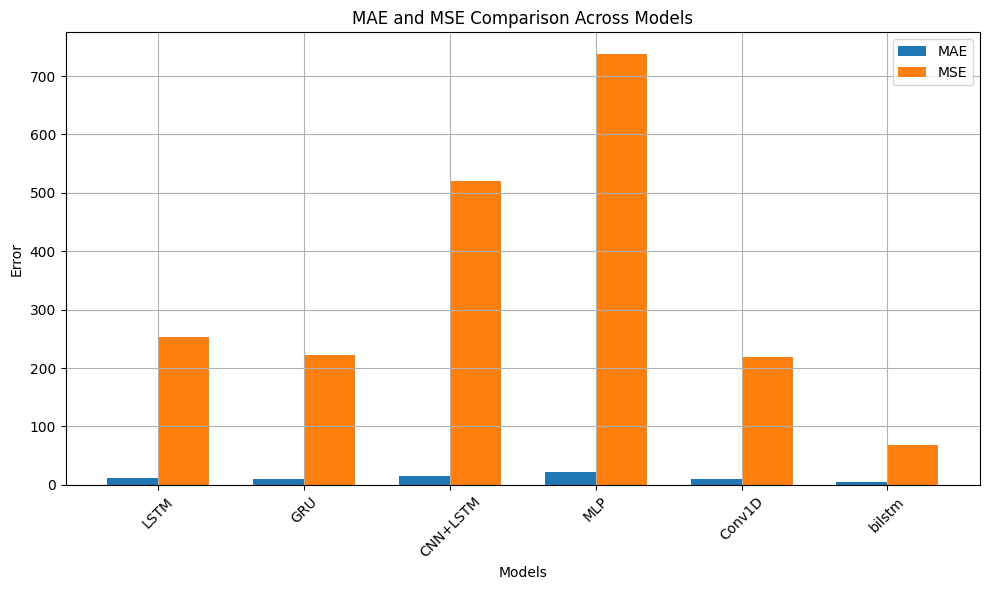

In [ ]:
# Plotting results
model_names = list(results.keys())
maes = [results[m]['mae'] for m in model_names]
mses = [results[m]['mse'] for m in model_names]

x = range(len(model_names))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, maes, width=width, label='MAE', align='center')
plt.bar([p + width for p in x], mses, width=width, label='MSE', align='center')

plt.xlabel('Models')
plt.ylabel('Error')
plt.title('MAE and MSE Comparison Across Models')
plt.xticks([p + width / 2 for p in x], model_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

winer model : **bilstm**

**Essayer une architecture plus profonde**

In [ ]:
def create_bilstm_model_2(window_size):
    """
    Creates a Bidirectional LSTM model with a deeper architecture.

    Args:
        window_size (int): The size of the input window (sequence length).

    Returns:
        tf.keras.models.Sequential: The compiled Keras model.
    """
    model = tf.keras.models.Sequential([
        Input(shape=(window_size, 2)),
        Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(64, activation='relu', return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(32, activation='relu')),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

seq_length = 5

model2 = create_bilstm_model_2(seq_length)
_ , mae , mse = train_model( df , model2 , 10, 16)
print(f' Real-scale MAE: {mae:.4f}, MSE: {mse:.4f}')

loss = 0.0011, mae = 0.0244
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
 Real-scale MAE: 26.0142, MSE: 1118.1473


The model’s accuracy deteriorated significantly.

eliminer  les couches de drop-out

In [ ]:
def create_bilstm_model_2(window_size):
    model = tf.keras.models.Sequential([
        Input(shape=(window_size, 2)),
        Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
        Bidirectional(LSTM(64, activation='relu', return_sequences=True)),
        Bidirectional(LSTM(32, activation='relu')),
        Dense(32, activation='relu'),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

seq_length = 5

model = create_bilstm_model_2(seq_length)
_ , mae , mse = train_model(df , model , 10, 16)
print(f' model : {name}  ,  Real-scale MAE: {mae:.4f}, MSE: {mse:.4f}')

loss = 0.0001, mae = 0.0078
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step
 model : bilstm  ,  Real-scale MAE: 8.3381, MSE: 136.6769


deeper architecture give bad results to **-21%** and a run time of 13 min compared to 5 min in light model

**try combined loss function**

In [ ]:
def euclidean_distance_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(
        tf.square(y_true[:, 0] - y_pred[:, 0]) +
        tf.square(y_true[:, 1] - y_pred[:, 1])
    ))

def build_model(seq_length):
    model = tf.keras.models.Sequential([
        Input(shape=(seq_length, 2)),
        Bidirectional(LSTM(64, activation='relu')),
        Dense(2)
    ])

    model.compile(
    optimizer='adam',
    loss=euclidean_distance_loss,
    metrics=['mae']
    )
    return model

In [ ]:
seq_length = 5

combined_model = build_model(seq_length)
_ , mae , mse = train_model(df , combined_model )
print(f' model : {name}  ,  Real-scale MAE: {mae:.4f}, MSE: {mse:.4f}')

loss = 0.0081, mae = 0.0051
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
 model : bilstm  ,  Real-scale MAE: 5.7217, MSE: 65.3996


**Conclusion :** using a combined loss function hase improved the model by **3,4%**


**trying different batch size**

In [ ]:
batch_sizes = {8 ,16 , 32 , 64}
for batch_size in batch_sizes:
    model = create_bilstm_model(seq_length)
    _ , mae , mse = train_model(df , model , 5, 10 , batch_size)

    print(f' batch size : {batch_size:.4f}  ,  Real-scale MAE: {mae:.4f}, MSE: {mse:.4f}')

skipped tornadoe : 37
loss = 0.0000, mae = 0.0040
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
 batch size : 8.0000  ,  Real-scale MAE: 4.2693, MSE: 41.3673
skipped tornadoe : 37
loss = 0.0001, mae = 0.0060
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
 batch size : 16.0000  ,  Real-scale MAE: 7.0561, MSE: 98.0092
skipped tornadoe : 37
loss = 0.0002, mae = 0.0094
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
 batch size : 32.0000  ,  Real-scale MAE: 9.6318, MSE: 166.4976
skipped tornadoe : 37
loss = 0.0002, mae = 0.0097
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
 batch size : 64.0000  ,  Real-scale MAE: 10.2850, MSE: 205.4332


In [ ]:
batch_sizes = {8 ,16 , 32 , 64}
for batch_size in batch_sizes:
    model = build_model(seq_length)
    _ , mae , mse = train_model(df , model , 5, 10 , batch_size)
    print(f' batch size : {batch_size:.4f}  ,  Real-scale MAE: {mae:.4f}, MSE: {mse:.4f}')

skipped tornadoe : 37
loss = 0.0064, mae = 0.0041
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
 batch size : 8.0000  ,  Real-scale MAE: 4.4519, MSE: 48.0461
skipped tornadoe : 37
loss = 0.0081, mae = 0.0051
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
 batch size : 16.0000  ,  Real-scale MAE: 5.7217, MSE: 65.3996
skipped tornadoe : 37
loss = 0.0123, mae = 0.0077
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
 batch size : 32.0000  ,  Real-scale MAE: 8.1376, MSE: 133.6091
skipped tornadoe : 37
loss = 0.0151, mae = 0.0094
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
 batch size : 64.0000  ,  Real-scale MAE: 9.3051, MSE: 165.3393


**trying different sequence lenght**

In [ ]:
# def train_model(df, model, seq_length = 5 ,epochs=10, batch_size=16 , seed = 42 , ):
seq_lengths = [ 3 ,5 , 10 , 15 ]
for seq in seq_lengths:
    model = build_model(seq)
    _ , mae , mse = train_model(df , model , seq , 10 , 8)
    print(f' seq length : {seq:.4f}  ,  Real-scale MAE: {mae:.4f}, MSE: {mse:.4f}')

skipped tornadoe : 21
loss = 0.0072, mae = 0.0045
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
 seq length : 3.0000  ,  Real-scale MAE: 4.6568, MSE: 44.0760
skipped tornadoe : 37
loss = 0.0064, mae = 0.0041
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
 seq length : 5.0000  ,  Real-scale MAE: 4.4519, MSE: 48.0461
skipped tornadoe : 247
loss = 0.0070, mae = 0.0044
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
 seq length : 10.0000  ,  Real-scale MAE: 4.4681, MSE: 42.6796
skipped tornadoe : 578
loss = 0.0129, mae = 0.0082
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
 seq length : 15.0000  ,  Real-scale MAE: 8.9574, MSE: 149.3246


In [ ]:
# def train_model(df, model, seq_length = 5 ,epochs=10, batch_size=16 , seed = 42 , )
seq_lengths = [  3 ,5 , 10 , 15 ]
for seq in seq_lengths:
    model = create_bilstm_model(seq)
    _ , mae , mse = train_model(df , model , seq , 10 , 8)
    print(f' seq length : {seq:.4f}  ,  Real-scale MAE: {mae:.4f}, MSE: {mse:.4f}')

skipped tornadoe : 21
loss = 0.0000, mae = 0.0048
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
 seq length : 3.0000  ,  Real-scale MAE: 5.4504, MSE: 54.6241
skipped tornadoe : 37
loss = 0.0000, mae = 0.0040
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
 seq length : 5.0000  ,  Real-scale MAE: 4.2693, MSE: 41.3673
skipped tornadoe : 247
loss = 0.0000, mae = 0.0049
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
 seq length : 10.0000  ,  Real-scale MAE: 5.1745, MSE: 53.6601
skipped tornadoe : 578
loss = 0.0002, mae = 0.0112
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
 seq length : 15.0000  ,  Real-scale MAE: 12.1557, MSE: 266.5956


**trying normalizing by tornado**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

X_train, y_train, X_test, y_test = [], [], [], []
test_ids = []    # <-- on ajoutera l'ID de chaque échantillon test ici
scalers = {}

for tornado_id, group in df.groupby('cyclone_id'):
    group = group.reset_index(drop=True)

    # Standardisation par cyclone
    scaler = MinMaxScaler()
    group[['latitude', 'longitude']] = scaler.fit_transform(group[['latitude', 'longitude']])
    scalers[tornado_id] = scaler

    split_idx = int(len(group) * 0.7)
    train_group = group[:split_idx]
    test_group  = group[split_idx:]

    x_tr, y_tr = create_sequences(train_group, seq_length)
    x_te, y_te = create_sequences(test_group, seq_length)

    if len(x_tr) > 0 and len(x_te) > 0:
        X_train.append(x_tr)
        y_train.append(y_tr)

        X_test.append(x_te)
        y_test.append(y_te)

        # Pour chaque séquence test (de taille seq_length), on stocke son ID
        # On crée un tableau de la même longueur que y_te, rempli avec tornado_id
        test_ids.append(np.full(shape=(y_te.shape[0],), fill_value=tornado_id, dtype=object))

# Concaténation finale
X_train = np.concatenate(X_train).astype(np.float32)
y_train = np.concatenate(y_train).astype(np.float32)

X_test  = np.concatenate(X_test).astype(np.float32)
y_test  = np.concatenate(y_test).astype(np.float32)
test_ids = np.concatenate(test_ids)  # vecteur d’ID, longueur = nombre total d’échantillons test

model = create_bilstm_model(5)
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=8,
    validation_split=0.3,
    verbose=0
)
y_pred_scaled = model.predict(X_test)
# Initialisation des tableaux pour stocker les vraies valeurs et prédictions en échelle réelle
y_true_real = np.zeros_like(y_test)       # même shape que y_test
y_pred_real = np.zeros_like(y_pred_scaled)

for i in range(len(y_test)):
    tornado_id = test_ids[i]
    scaler     = scalers[tornado_id]

    # y_test[i] est e.g. array([lat_scaled, lon_scaled])
    # on fait reshape(1,2) pour satisfaire l’API de inverse_transform
    real_true = scaler.inverse_transform(y_test[i].reshape(1, -1))
    real_pred = scaler.inverse_transform(y_pred_scaled[i].reshape(1, -1))

    y_true_real[i] = real_true
    y_pred_real[i] = real_pred
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Supposons que y_true_real et y_pred_real ont shape (N_test, 2) pour (lat, lon)
mae_lat = mean_absolute_error(y_true_real[:, 0], y_pred_real[:, 0])
mae_lon = mean_absolute_error(y_true_real[:, 1], y_pred_real[:, 1])

mse_lat = mean_squared_error(y_true_real[:, 0], y_pred_real[:, 0])
mse_lon = mean_squared_error(y_true_real[:, 1], y_pred_real[:, 1])

print(f"MAE Latitude réel   : {mae_lat:.4f}")
print(f"MAE Longitude réel  : {mae_lon:.4f}")
print(f"MSE Latitude réel   : {mse_lat:.4f}")
print(f"MSE Longitude réel  : {mse_lon:.4f}")

# Si vous voulez un RMSE global (pour les deux dimensions), par exemple :
rmse_global = np.sqrt(
    mean_squared_error(
        y_true_real.reshape(-1, 2),
        y_pred_real.reshape(-1, 2)
    )
)
print(f"RMSE global (2D)    : {rmse_global:.4f}")


285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
MAE Latitude réel   : 3.1831
MAE Longitude réel  : 4.9933
MSE Latitude réel   : 20.0786
MSE Longitude réel  : 53.4726
RMSE global (2D)    : 6.0643


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

X_train, y_train, X_test, y_test = [], [], [], []
test_ids = []    # <-- on ajoutera l'ID de chaque échantillon test ici
scalers = {}
seq_length = 5
for tornado_id, group in df.groupby('cyclone_id'):
    group = group.reset_index(drop=True)

    # Standardisation par cyclone
    scaler = MinMaxScaler()
    group[['latitude', 'longitude']] = scaler.fit_transform(group[['latitude', 'longitude']])
    scalers[tornado_id] = scaler

    split_idx = int(len(group) * 0.7)
    train_group = group[:split_idx]
    test_group  = group[split_idx:]

    x_tr, y_tr = create_sequences(train_group, seq_length)
    x_te, y_te = create_sequences(test_group, seq_length)

    if len(x_tr) > 0 and len(x_te) > 0:
        X_train.append(x_tr)
        y_train.append(y_tr)

        X_test.append(x_te)
        y_test.append(y_te)

        # Pour chaque séquence test (de taille seq_length), on stocke son ID
        test_ids.append(np.full(shape=(y_te.shape[0],), fill_value=tornado_id, dtype=object))

# Concaténation finale
X_train = np.concatenate(X_train).astype(np.float32)
y_train = np.concatenate(y_train).astype(np.float32)

X_test  = np.concatenate(X_test).astype(np.float32)
y_test  = np.concatenate(y_test).astype(np.float32)
test_ids = np.concatenate(test_ids)  # vecteur d’ID, longueur = nombre total d’échantillons test

model = create_bilstm_model(5)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_split=0.3,
    verbose=1
)
y_pred_scaled = model.predict(X_test)
# Initialisation des tableaux pour stocker les vraies valeurs et prédictions en échelle réelle
y_true_real = np.zeros_like(y_test)       # même shape que y_test
y_pred_real = np.zeros_like(y_pred_scaled)

for i in range(len(y_test)):
    tornado_id = test_ids[i]
    scaler     = scalers[tornado_id]

    # y_test[i] est e.g. array([lat_scaled, lon_scaled])
    # on fait reshape(1,2) pour satisfaire l’API de inverse_transform
    real_true = scaler.inverse_transform(y_test[i].reshape(1, -1))
    real_pred = scaler.inverse_transform(y_pred_scaled[i].reshape(1, -1))

    y_true_real[i] = real_true
    y_pred_real[i] = real_pred
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Supposons que y_true_real et y_pred_real ont shape (N_test, 2) pour (lat, lon)
mae_lat = mean_absolute_error(y_true_real[:, 0], y_pred_real[:, 0])
mae_lon = mean_absolute_error(y_true_real[:, 1], y_pred_real[:, 1])

mse_lat = mean_squared_error(y_true_real[:, 0], y_pred_real[:, 0])
mse_lon = mean_squared_error(y_true_real[:, 1], y_pred_real[:, 1])

print(f"MAE Latitude réel   : {mae_lat:.4f}")
print(f"MAE Longitude réel  : {mae_lon:.4f}")
print(f"MSE Latitude réel   : {mse_lat:.4f}")
print(f"MSE Longitude réel  : {mse_lon:.4f}")

# Si vous voulez un RMSE global (pour les deux dimensions), par exemple :
rmse_global = np.sqrt(
    mean_squared_error(
        y_true_real.reshape(-1, 2),
        y_pred_real.reshape(-1, 2)
    )
)
print(f"RMSE global (2D)    : {rmse_global:.4f}")


Epoch 1/100
2820/2820 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.0093 - mae: 0.0557 - val_loss: 9.5522e-04 - val_mae: 0.0214
Epoch 2/100
2820/2820 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0011 - mae: 0.0223 - val_loss: 8.6617e-04 - val_mae: 0.0228
Epoch 3/100
2820/2820 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 7.5782e-04 - mae: 0.0183 - val_loss: 4.6625e-04 - val_mae: 0.0143
Epoch 4/100
2820/2820 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 6.3157e-04 - mae: 0.0162 - val_loss: 5.5403e-04 - val_mae: 0.0174
Epoch 5/100
2820/2820 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 5.5241e-04 - mae: 0.0149 - val_loss: 3.8884e-04 - val_mae: 0.0125
Epoch 6/100
2820/2820 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 5.0659e-04 - mae: 0.0142 - val_loss: 3.9483e-04 - val_mae: 0.0123
Epoch 7/100
2820/2820 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 5.1464e-04 - mae: 0.0142 - val_loss: 3.8430e-04 - val_mae: 0.0119
Epoch 8/100
2820/2820 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 4.9983e-04 - mae: 0.0136 - val_los

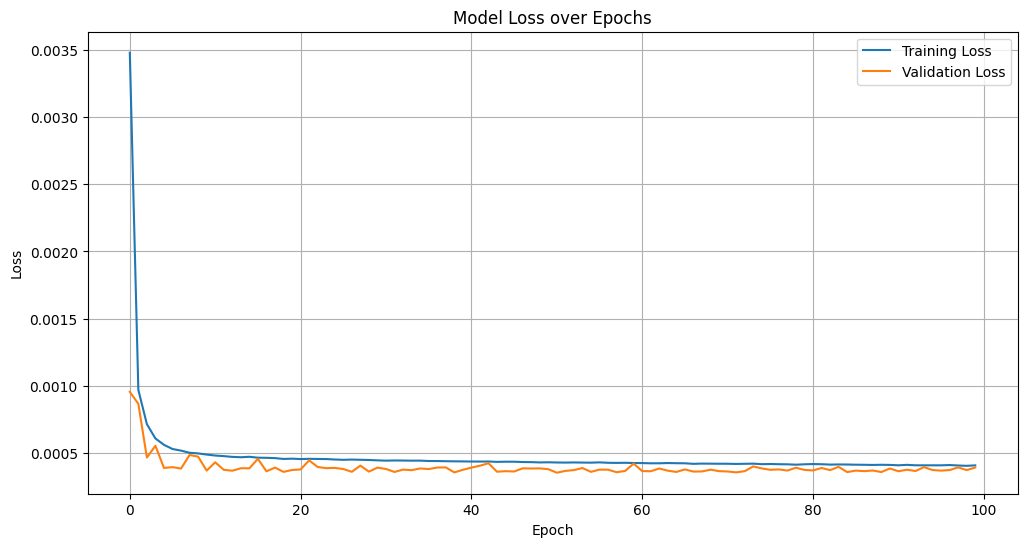

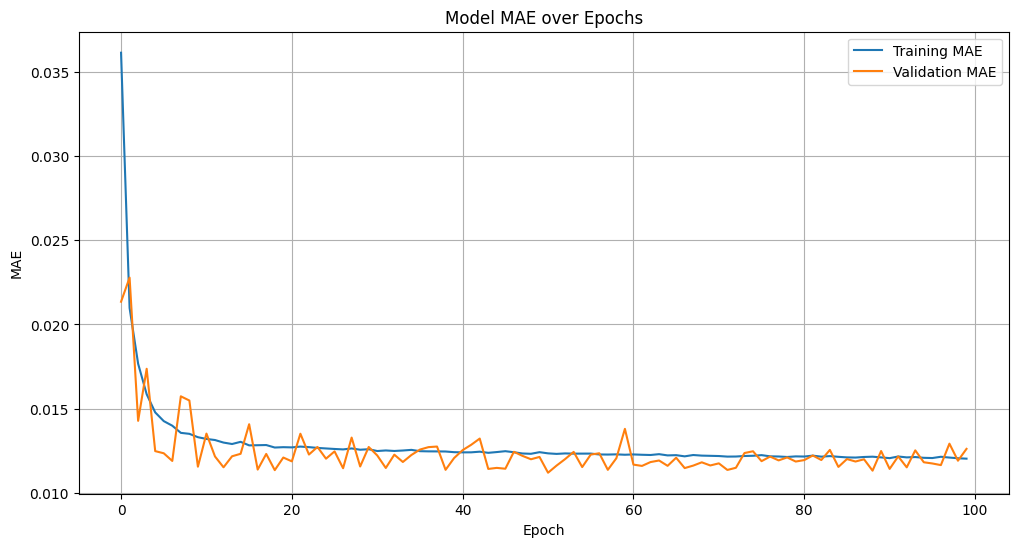

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
if 'val_mae' in history.history:
    plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

**explore num epoch needed**

In [ ]:
seq_length = 5
model = create_bilstm_model(seq_length)
history , mae , mse = train_model(df , model , seq_length , 60 , 8)

skipped tornadoe : 37
loss = 0.0000, mae = 0.0037
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
print(f'Real-scale MAE: {mae:.4f}, MSE: {mse:.4f}')

Real-scale MAE: 3.9101, MSE: 34.7803


In [ ]:
model.save('bilstm_model.h5')

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        34,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,688 (405.04 KB)

 Trainable params: 34,562 (135.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 69,126 (270.03 KB)

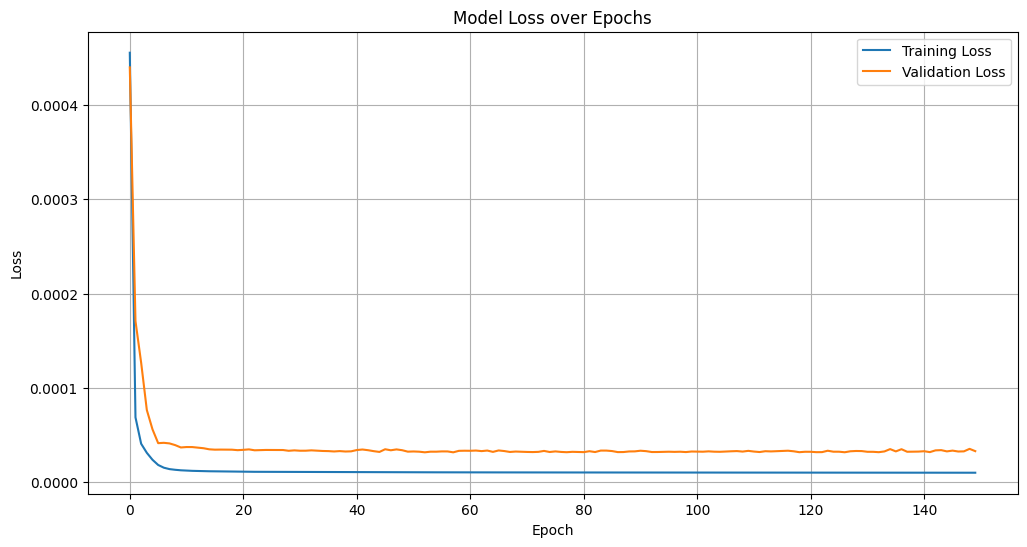

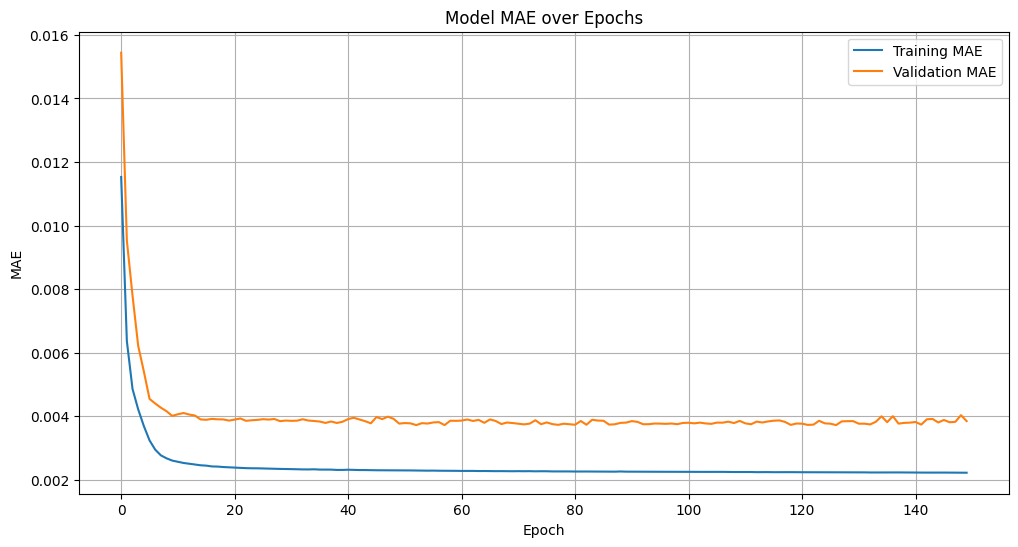

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
if 'val_mae' in history.history:
    plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

**Differente optimizers**


🚀 Training BiLSTM model with optimizer: Adam
skipped tornadoe : 37
loss = 0.0000, mae = 0.0040
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Optimizer: Adam | Real-scale MAE = 4.2693 | Real-scale MSE = 41.3673

🚀 Training BiLSTM model with optimizer: RMSprop
skipped tornadoe : 37
loss = 0.0001, mae = 0.0078
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Optimizer: RMSprop | Real-scale MAE = 9.0301 | Real-scale MSE = 154.0797

🚀 Training BiLSTM model with optimizer: Adagrad
skipped tornadoe : 37
loss = 0.0009, mae = 0.0231
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Optimizer: Adagrad | Real-scale MAE = 25.8452 | Real-scale MSE = 1275.2479

🚀 Training BiLSTM model with optimizer: Nadam
skipped tornadoe : 37
loss = 0.0000, mae = 0.0049
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Optimizer: Nadam | Real-scale MAE = 4.9257 | Real-scale MSE = 46.6625

🚀 Training BiLSTM model with optimizer: Ftrl
skipped tornadoe : 37
loss = 0.0372, mae = 0.1532
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Optimizer: Ftrl | Rea

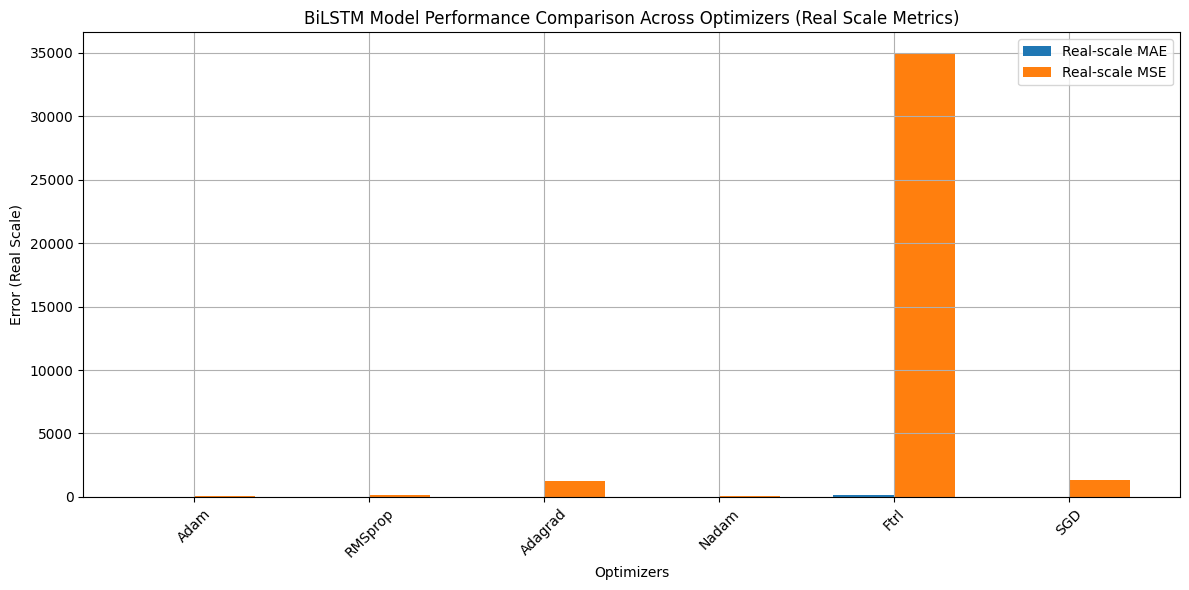


--- Optimizer Benchmark Results ---
Optimizer  | Real-scale MAE  | Real-scale MSE 
---------------------------------------------
Adam       | 4.2693          | 41.3673        
RMSprop    | 9.0301          | 154.0797       
Adagrad    | 25.8452         | 1275.2479      
Nadam      | 4.9257          | 46.6625        
Ftrl       | 155.6094        | 34883.6641     
SGD        | 26.5162         | 1355.8380      


In [ ]:
# prompt: generer un benchmark de optimizers pour le bilstm model

import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, Nadam, Ftrl, SGD

def create_bilstm_model_optimizer(window_size, optimizer):
    """
    Creates a Bidirectional LSTM model with a specified optimizer.

    Args:
        window_size (int): The size of the input window (sequence length).
        optimizer: The Keras optimizer instance to use.

    Returns:
        tf.keras.models.Sequential: The compiled Keras model.
    """
    model = tf.keras.models.Sequential([
        Input(shape=(window_size, 2)),
        Bidirectional(LSTM(64, activation='relu')),
        Dense(2)
    ])
    # Compile with both loss and mae
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

seq_length = 5
epochs = 10
batch_size = 8

optimizers = {
    'Adam': Adam(learning_rate=0.001),
    'RMSprop': RMSprop(learning_rate=0.001),
    'Adagrad': Adagrad(learning_rate=0.01),
    'Nadam': Nadam(learning_rate=0.002),
    'Ftrl': Ftrl(learning_rate=0.001),
    'SGD': SGD(learning_rate=0.01),
}

optimizer_results = {}

for opt_name, optimizer_instance in optimizers.items():
    print(f"\n🚀 Training BiLSTM model with optimizer: {opt_name}")

    # Create a new model instance for each optimizer to ensure a clean state
    model = create_bilstm_model_optimizer(seq_length, optimizer_instance)

    # Use the train_model function (assuming it's appropriate for this model)
    # train_model returns history, mae, mse (real-scale)
    _, mae, mse = train_model(df, model, seq_length=seq_length, epochs=epochs, batch_size=batch_size, seed=42)

    optimizer_results[opt_name] = {'mae': mae, 'mse': mse}
    print(f'Optimizer: {opt_name} | Real-scale MAE = {mae:.4f} | Real-scale MSE = {mse:.4f}')


# Plotting results
optimizer_names = list(optimizer_results.keys())
opt_maes = [optimizer_results[opt]['mae'] for opt in optimizer_names]
opt_mses = [optimizer_results[opt]['mse'] for opt in optimizer_names]

x = range(len(optimizer_names))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x, opt_maes, width=width, label='Real-scale MAE', align='center')
plt.bar([p + width for p in x], opt_mses, width=width, label='Real-scale MSE', align='center')

plt.xlabel('Optimizers')
plt.ylabel('Error (Real Scale)')
plt.title('BiLSTM Model Performance Comparison Across Optimizers (Real Scale Metrics)')
plt.xticks([p + width / 2 for p in x], optimizer_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Print results in a table format
print("\n--- Optimizer Benchmark Results ---")
print("{:<10} | {:<15} | {:<15}".format("Optimizer", "Real-scale MAE", "Real-scale MSE"))
print("-" * 45)
for opt_name, metrics in optimizer_results.items():
    print("{:<10} | {:<15.4f} | {:<15.4f}".format(opt_name, metrics['mae'], metrics['mse']))
